In [1]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    average_precision_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
)
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Load dataset
original_idx_columns = ["Unnamed: 0", "purchase_count_by_device", "purchase_count_by_ip"]# and duplicates
train_df = pd.read_csv("../data/train.csv").drop(columns=original_idx_columns)
test_df = pd.read_csv("../data/test.csv").drop(columns=original_idx_columns)

# Quick sanity check
print("Dataset shape:", train_df.shape)
print(train_df["class"].value_counts(normalize=True))

Dataset shape: (120889, 55)
class
0    0.906352
1    0.093648
Name: proportion, dtype: float64


In [ ]:
def train_test_split_index(train_df, test_df, test_size=0.2, random_state=42):
    rows = len(train_df)
    indices = np.arange(rows)
    y = train_df["class"]
    
    train_indices, test_indices = train_test_split(
        indices,
        test_size=test_size,
        random_state=random_state,
        stratify=y
    )

    # Select corresponding samples
    train = train_df.iloc[train_indices]
    test = test_df.iloc[test_indices]

    return train, test

In [6]:
DROP_COLS = [
    "user_id", "signup_time", "purchase_time",
    "device_id", "ip_address", "country", 
    "sex", "age", "age_group", "trasactions_by_user_id"
]
num = [f for f in train_df.columns if train_df[f].dtype in ["int64", "float64"] and f not in DROP_COLS]

In [7]:
def identify_highly_correlated():
    corr_map = {'0.7-0.8': [], '0.8-0.9': [], '0.9-1': []}
    num_corr_df = train_df[num].corr()
    index = num_corr_df.index
    cols = num_corr_df.columns
    for idx, row in enumerate(index):
        for j in range(idx+1, len(cols)):
            col = cols[j]
            corr_coef = num_corr_df.loc[row, col]
            if abs(corr_coef) >= 0.9:
                corr_map['0.9-1'].append([row, col])
            elif abs(corr_coef) >= 0.8:
                corr_map['0.8-0.9'].append([row, col])
            elif abs(corr_coef) >= 0.7:
                corr_map['0.7-0.8'].append([row, col])
    return corr_map, num_corr_df


In [8]:
corr_map, corr_df = identify_highly_correlated()

In [9]:
corr_map['0.9-1']

[['purchase_value', 'purchase_mean_by_device'],
 ['purchase_value', 'purchase_mean_by_ip'],
 ['txn_count_by_device', 'txn_count_by_ip'],
 ['txn_count_by_device', 'txn_count_device_zscore'],
 ['txn_count_by_device', 'txn_count_ip_zscore'],
 ['txn_count_by_device', 'txn_count_ip_percentile'],
 ['txn_count_by_device', 'purchase_std_by_ip'],
 ['txn_count_by_device', 'is_unique_ip'],
 ['txn_count_by_ip', 'txn_count_device_zscore'],
 ['txn_count_by_ip', 'txn_count_ip_zscore'],
 ['txn_count_by_ip', 'txn_count_ip_percentile'],
 ['txn_count_by_ip', 'time_since_last_ip_address_txn'],
 ['txn_count_by_ip', 'purchase_std_by_ip'],
 ['txn_count_by_ip', 'is_unique_ip'],
 ['txn_count_device_zscore', 'txn_count_ip_zscore'],
 ['txn_count_device_zscore', 'txn_count_ip_percentile'],
 ['txn_count_device_zscore', 'purchase_std_by_ip'],
 ['txn_count_device_zscore', 'is_unique_ip'],
 ['txn_count_ip_zscore', 'txn_count_ip_percentile'],
 ['txn_count_ip_zscore', 'time_since_last_ip_address_txn'],
 ['txn_count_ip_

## Logistic Regression

In [10]:
def transform(train, test):
    TARGET = "class"
    DROP_COLS = [
        "user_id", "signup_time", "purchase_time",
        "device_id", "ip_address", "country",
        "sex", "age", "transactions_by_user_id"
    ]

    # Keep boolean columns (already encoded)
    features = [col for col in train.columns if col not in DROP_COLS + [TARGET]]

    # Identify types
    numeric = [f for f in features if train[f].dtype in ["int64", "float64"]]
    categorical = ["source", "browser"]
    preencoded_bool = [f for f in features if train[f].dtype == "bool"]

    # Separate X and y
    X_train, y_train = train[features], train[TARGET]
    X_test, y_test = test[features], test[TARGET]

    # Column transformer for numeric + categorical
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), numeric),
            ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical)
        ],
        remainder='drop'
    )

    # Fit-transform on train, transform on test
    X_train_trans = preprocessor.fit_transform(X_train)
    X_test_trans = preprocessor.transform(X_test)

    # Get column names for transformed features
    num_features = numeric
    cat_features = preprocessor.named_transformers_["cat"].get_feature_names_out(categorical)
    base_features = list(num_features) + list(cat_features)

    # Convert to DataFrames
    X_train_scaled = pd.DataFrame(X_train_trans, columns=base_features, index=train.index)
    X_test_scaled = pd.DataFrame(X_test_trans, columns=base_features, index=test.index)

    # Add boolean (already-encoded) features back
    X_train_scaled = pd.concat([X_train_scaled, X_train[preencoded_bool]], axis=1)
    X_test_scaled = pd.concat([X_test_scaled, X_test[preencoded_bool]], axis=1)

    return X_train_scaled, X_test_scaled, y_train, y_test, features


In [11]:
X_train, X_test, y_train, y_test, features = transform(train_df, test_df)

In [26]:
import pandas as pd

def fit_predict_join(model, X_train, X_test, y_train, y_test, features, target_col="class"):
    """
    Fits a model, predicts on test data, and returns a test_df
    that includes predictions and true labels for analysis.

    Parameters
    ----------
    model : estimator
        Any sklearn-compatible model (e.g., LogisticRegression, RandomForestClassifier, etc.)
    X_train, X_test : pd.DataFrame
        Training and testing feature sets
    y_train, y_test : pd.Series or np.array
        Corresponding target labels
    target_col : str, optional
        Name of the target column for merging back into the test set

    Returns
    -------
    test_df : pd.DataFrame
        Test DataFrame including:
        - all original features
        - true labels (as `y_true`)
        - predicted labels (as `y_pred`)
        - predicted probabilities (as `y_proba`, if supported)
    model : fitted model
        Trained model for reuse or evaluation
    """

    # Fit model
    model.fit(X_train, y_train)

    # Predict on test set
    y_pred = model.predict(X_test)

    # Predict probabilities (if available)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        print("ROC-AUC:", roc_auc_score(y_test, y_proba))
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred, digits=4))
    else:
        y_proba = None

    # PR-AUC is a good metric for imbalanced datasets
    pr_auc = average_precision_score(y_test, y_pred)
    print(f"PR AUC (average_precision_score): {pr_auc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.show()

    # Join predictions back to X_test
    test_df = X_test.copy()
    test_df["y_true"] = y_test.values
    test_df["y_pred"] = y_pred
    if y_proba is not None:
        test_df["y_proba"] = y_proba

    feature_names = X_train.columns if hasattr(X_train, 'columns') else [f'feature_{i}' for i in range(X_train.shape[1])]

    if hasattr(model, 'coef_'):
        # Logistic Regression
        feature_importance = pd.DataFrame({
            'feature': feature_names,
            'coefficient': model.coef_[0]
        }).sort_values(by='coefficient', key=abs, ascending=False)

    elif hasattr(model, 'feature_importances_'):
        # Tree-based models (Random Forest, XGBoost)
        feature_importance = pd.DataFrame({
            'feature': feature_names,
            'importance': model.feature_importances_
        }).sort_values(by='importance', ascending=False)

    return y_pred, test_df, model,feature_importance


ROC-AUC: 0.7961321268142709

Classification Report:
              precision    recall  f1-score   support

           0     0.9538    0.9914    0.9722     27393
           1     0.8651    0.5350    0.6611      2830

    accuracy                         0.9486     30223
   macro avg     0.9095    0.7632    0.8167     30223
weighted avg     0.9455    0.9486    0.9431     30223

PR AUC (average_precision_score): 0.5064


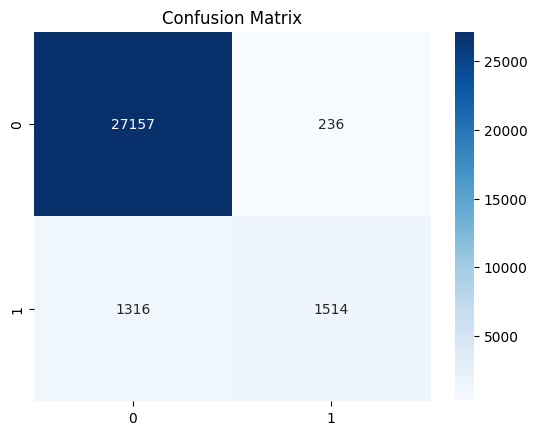

In [21]:
lr = LogisticRegression(
    solver='liblinear',
    class_weight='balanced', # to handle imbalance, fraud == 0.09
    max_iter=1000,
    random_state=42
)

y_pred_lr, modified_test_df, lr_model, importance = fit_predict_join(
    lr,
    X_train,
    X_test,
    y_train,
    y_test,
    features
)

## Misclassified Transactions

### Comparison of numerical features between True Positives and False Negatives (uncaught fraud transaction)

In [22]:
def important_feature_diff(data, importance, x="y_pred", n=5):
    try:
        cols = importance.feature.head(n).values.tolist()
        cols.extend(importance.feature.tail(n).values)
        print(cols)

        fig, ax = plt.subplots(nrows=len(cols), ncols=2, figsize=(n*4, n*8))

        for i, col in enumerate(cols):
            sns.boxplot(x=x, y=col, data=data, ax=ax[i][0])
            sns.kdeplot(data, x=col, hue=x, ax=ax[i][1])
        
        plt.show()

    except Exception as e:
        print(f"{e}: {data[[col]]}")

['time_since_last_ip_address_txn', 'fraud_rate_by_month', 'txn_count_ip_zscore', 'txn_count_by_ip', 'purchase_cv_by_device', 'age_over_65', 'source_SEO', 'purchase_std_by_ip', 'is_unique_ip', 'is_unique_device']


/var/folders/l3/pxhbl0b94cdd7tr_xs9sbypc0000gn/T/ipykernel_11811/2582416916.py:11: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data, x=col, hue=x, ax=ax[i][1])
/var/folders/l3/pxhbl0b94cdd7tr_xs9sbypc0000gn/T/ipykernel_11811/2582416916.py:11: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data, x=col, hue=x, ax=ax[i][1])
/var/folders/l3/pxhbl0b94cdd7tr_xs9sbypc0000gn/T/ipykernel_11811/2582416916.py:11: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data, x=col, hue=x, ax=ax[i][1])
/var/folders/l3/pxhbl0b94cdd7tr_xs9sbypc0000gn/T/ipykernel_11811/2582416916.py:11: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data, x=col, hue=x, ax=ax[i][1])


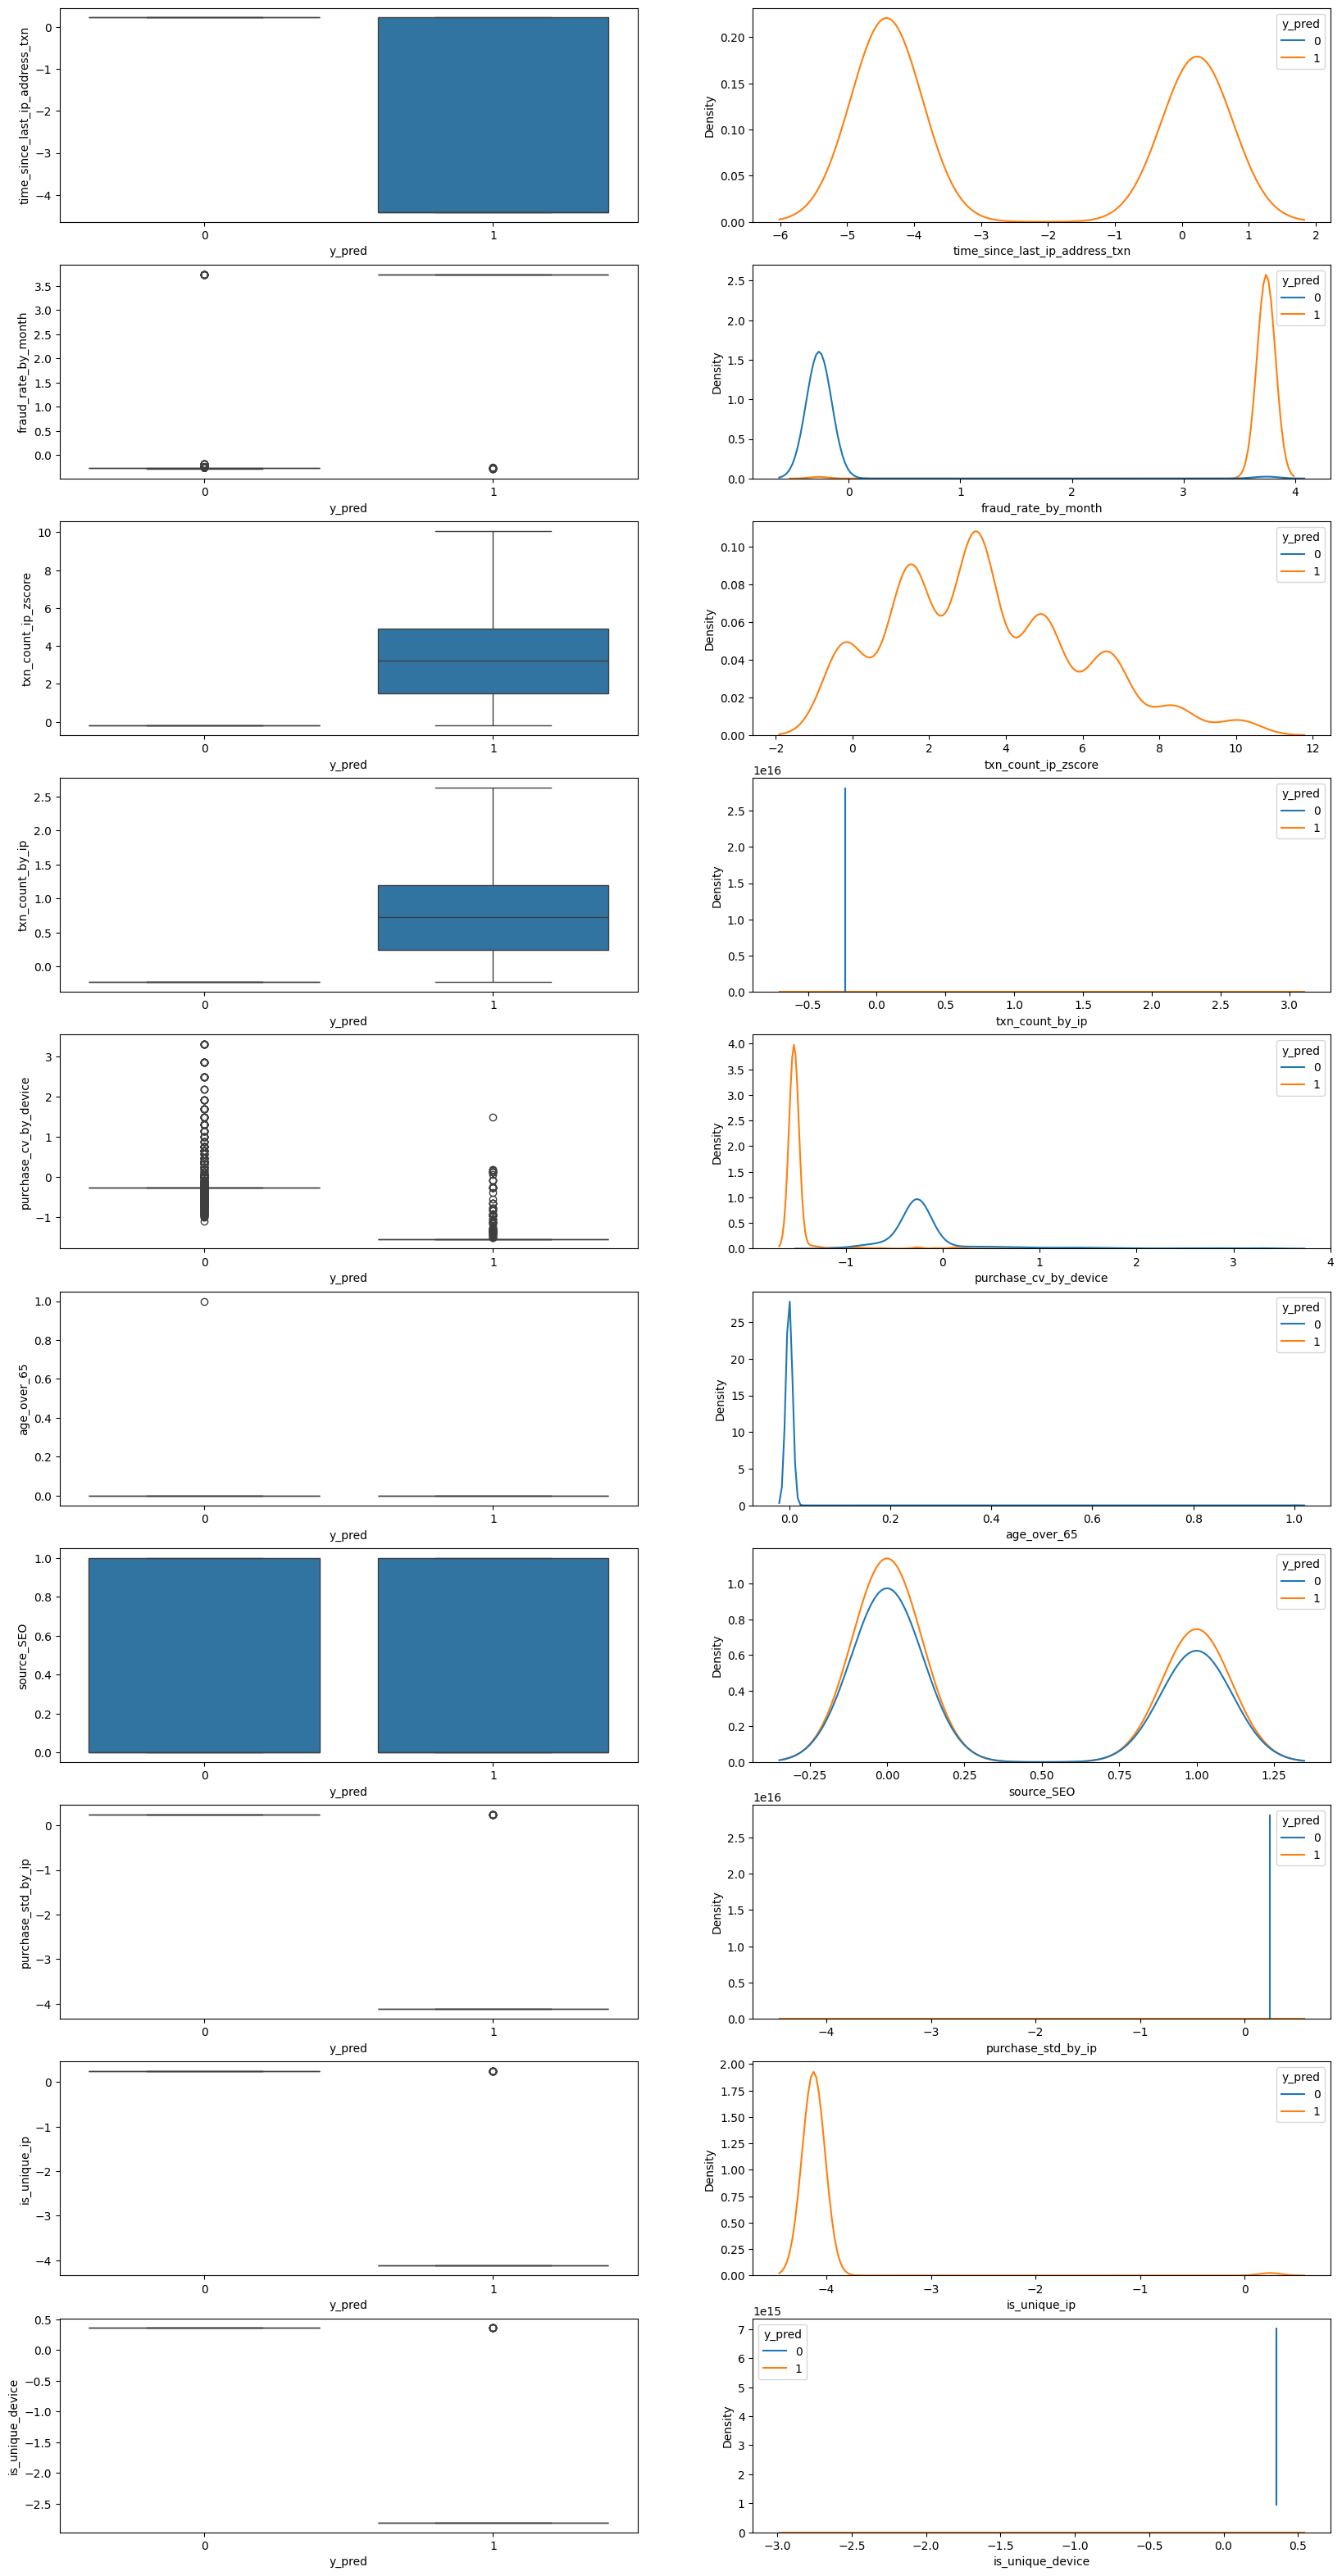

In [15]:
data = modified_test_df[modified_test_df["y_true"]==1]
important_feature_diff(data, importance, "y_pred", 5)

! to be re-evaluated due to train test contamination previously

This section investigates **fraudulent transactions that were not correctly predicted (False Negatives)** compared to those correctly identified (True Positives). The goal is to understand potential reasons for model misclassification and guide feature refinement.

---

#### 1. **`fraud_rate_by_month`**

* **Observation:**
  EDA revealed that almost all months (except January) exhibit a consistent **95:5 ratio of non-fraudulent to fraudulent transactions**.
  The logistic regression model may have overfitted this pattern, assigning excessive importance to month-related variables (`transaction_month`, `month_sin`, `month_cos`, `fraud_rate_by_month`).
* **Impact:**
  Fraudulent transactions occurring in “non-fraudulent” months were often **misclassified as legitimate**.
* **Next steps:**

  * Reduce the effect of month on the model:

    * Drop or regularize month-based features.
    * Replace raw month indicators with **rolling fraud rates** or **seasonal anomaly features** if time continuity exists.
    * Use tree-based models (e.g., XGBoost) which can capture non-linear patterns more robustly.

---

#### 2. **`time_since_last_ip_address_txn`**

* **Observation:**
  Fraudulent transactions correctly identified by the model are **spread across various time intervals**, while misclassified frauds are **clustered at higher time gaps** between transactions.
  In EDA, many IPs/devices conducted **bursts of rapid transactions (1s apart)** ending with a fraudulent one — this temporal pattern was not captured by a static logistic regression model.
* **Impact:**
  Fraud that occurs after long inactivity (or at the end of a burst) may not be detected.
* **Next steps:**

  * Introduce **recency-based risk scores** (e.g., exponential decay weighting).
  * Consider **time-series models** (e.g., sequence-aware features or recurrent embeddings).
  * Add a **binary “burst pattern” indicator** (e.g., whether several transactions occurred within short time gaps).

---

#### 3. **`txn_count_ip_zscore` and transaction count features**

* **Observation:**
  `txn_count_ip_zscore` and `transactions_by_ip_address` encode similar information — the **relative activity** of an IP address.
  If most IPs make only one transaction, their z-score ≈ 0, causing limited signal for fraud detection.
* **Impact:**
  Transactions from IPs with “normal” counts may not stand out even if fraudulent.
* **Next steps:**

  * Remove duplicate or redundant count features.
  * Replace z-scores with **percentile-based rarity indicators** or **log-transformed counts**.

---

#### 4. **`source_seo` and `age_group_18_25`**

* **Observation:**
  Distributions of these features in True Positive (TP) and False Negative (FN) sets are nearly identical, suggesting **little discriminative power**.
* **Impact:**
  The model is learning noise from these features rather than useful signal.
* **Next steps:**

  * Drop or regularize these features.
  * Consider interaction terms (e.g., `source × browser`, `age_group × device_type`) instead, to uncover deeper patterns.

---

#### 5. **`is_unique_ip` / `is_unique_device`**

* **Observation:**
  While the distribution differs significantly between TP and FN, it remains **semantically important**: most repeated IPs/devices are indeed associated with fraud.
* **Impact:**
  Retaining this feature is justified — it captures an authentic behavioral signal.
* **Next steps:**

  * Keep the feature.
  * Complement it with **frequency** and **reuse recency** metrics.

---

#### 6. **`purchase_std_by_ip`**

* **Observation:**
  Measures how varied purchase values from the same IP are.
  Fraudsters often transact multiple times with similar purchase amounts, making this a potentially strong indicator.
* **Next steps:**

  * Retain the feature.
  * If possible, normalize by average transaction size to improve cross-IP comparability.

---

### 🧭 Summary of Feature Actions

| Feature                                                              | Decision          | Reason                          |
| -------------------------------------------------------------------- | ----------------- | ------------------------------- |
| `fraud_rate_by_month`, `transaction_month`, `month_sin`, `month_cos` | Drop / Regularize | Overstates month influence      |
| `time_since_last_ip_address_txn`                                     | Refine            | Capture short bursts / recency  |
| `txn_count_ip_zscore`, `transactions_by_ip_address`                  | Consolidate       | Redundant information           |
| `source_seo`, `age_18_25`                                            | Drop              | Low discriminative power        |
| `is_unique_ip`, `is_unique_device`                                   | Keep              | Strong fraud signal             |
| `purchase_std_by_ip`                                                 | Keep              | Reflects behavioral consistency |

---

In [23]:
def get_original_test_with_pred(test_df, y_pred, y_test):
    test_df["y_pred"] = y_pred
    test_df["y_true"] = y_test
    misclassified_lr = test_df[test_df["y_pred"] != test_df["y_true"]]
    fn_lr = misclassified_lr[misclassified_lr["y_pred"] == 0]
    fn_lr["signup_time"] = pd.to_datetime(fn_lr["signup_time"])
    fn_lr["purchase_time"] = pd.to_datetime(fn_lr["purchase_time"])
    return fn_lr

/var/folders/l3/pxhbl0b94cdd7tr_xs9sbypc0000gn/T/ipykernel_11811/2195830253.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fn_lr["signup_time"] = pd.to_datetime(fn_lr["signup_time"])
/var/folders/l3/pxhbl0b94cdd7tr_xs9sbypc0000gn/T/ipykernel_11811/2195830253.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fn_lr["purchase_time"] = pd.to_datetime(fn_lr["purchase_time"])


<Axes: xlabel='purchase_time', ylabel='Density'>

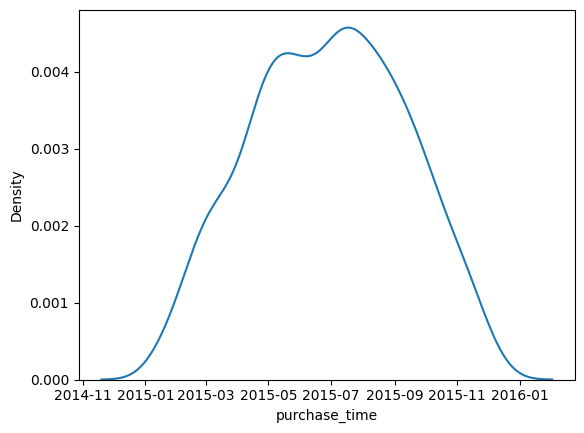

In [24]:
fn_lr = get_original_test_with_pred(test_df, y_pred_lr, y_test)
sns.kdeplot(fn_lr["purchase_time"])

## Random Forest

ROC-AUC: 0.7913859373683846

Classification Report:
              precision    recall  f1-score   support

           0     0.9477    1.0000    0.9731     27393
           1     1.0000    0.4654    0.6352      2830

    accuracy                         0.9499     30223
   macro avg     0.9738    0.7327    0.8041     30223
weighted avg     0.9526    0.9499    0.9415     30223

PR AUC (average_precision_score): 0.5154


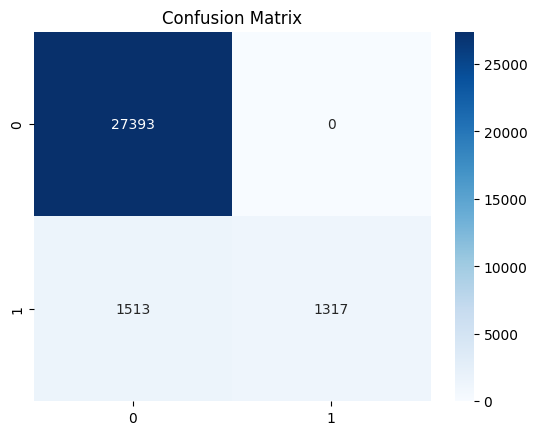

In [27]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,              # number of trees
    max_depth=None,                # let trees grow fully (you can tune later)
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight='balanced',       # handle class imbalance
    random_state=42,
    n_jobs=-1                      # use all cores
)

y_pred_rf, modified_test_df_rf, rf_model, rf_importance = fit_predict_join(
    rf,
    X_train,
    X_test,
    y_train,
    y_test,
    features
)

['time_setup_to_txn_seconds', 'txn_count_device_zscore', 'txn_count_device_percentile', 'txn_count_by_device', 'purchase_cv_by_device', 'is_unique_device', 'purchase_cv_by_ip', 'purchase_mean_by_device', 'purchase_value', 'purchase_mean_by_ip', 'sex_encoded', 'device_ip_consistency', 'browser_Opera', 'age_51_65', 'age_under_18', 'age_over_65', 'purchase_zscore_by_ip', 'purchase_deviation_from_ip_mean', 'is_ip_single_device', 'ip_device_consistency']


/var/folders/l3/pxhbl0b94cdd7tr_xs9sbypc0000gn/T/ipykernel_11811/2582416916.py:11: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data, x=col, hue=x, ax=ax[i][1])
/var/folders/l3/pxhbl0b94cdd7tr_xs9sbypc0000gn/T/ipykernel_11811/2582416916.py:11: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data, x=col, hue=x, ax=ax[i][1])
/var/folders/l3/pxhbl0b94cdd7tr_xs9sbypc0000gn/T/ipykernel_11811/2582416916.py:11: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data, x=col, hue=x, ax=ax[i][1])
/var/folders/l3/pxhbl0b94cdd7tr_xs9sbypc0000gn/T/ipykernel_11811/2582416916.py:11: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data, x=col, hue=x, ax=ax[i][1])
/var/folders/l3/

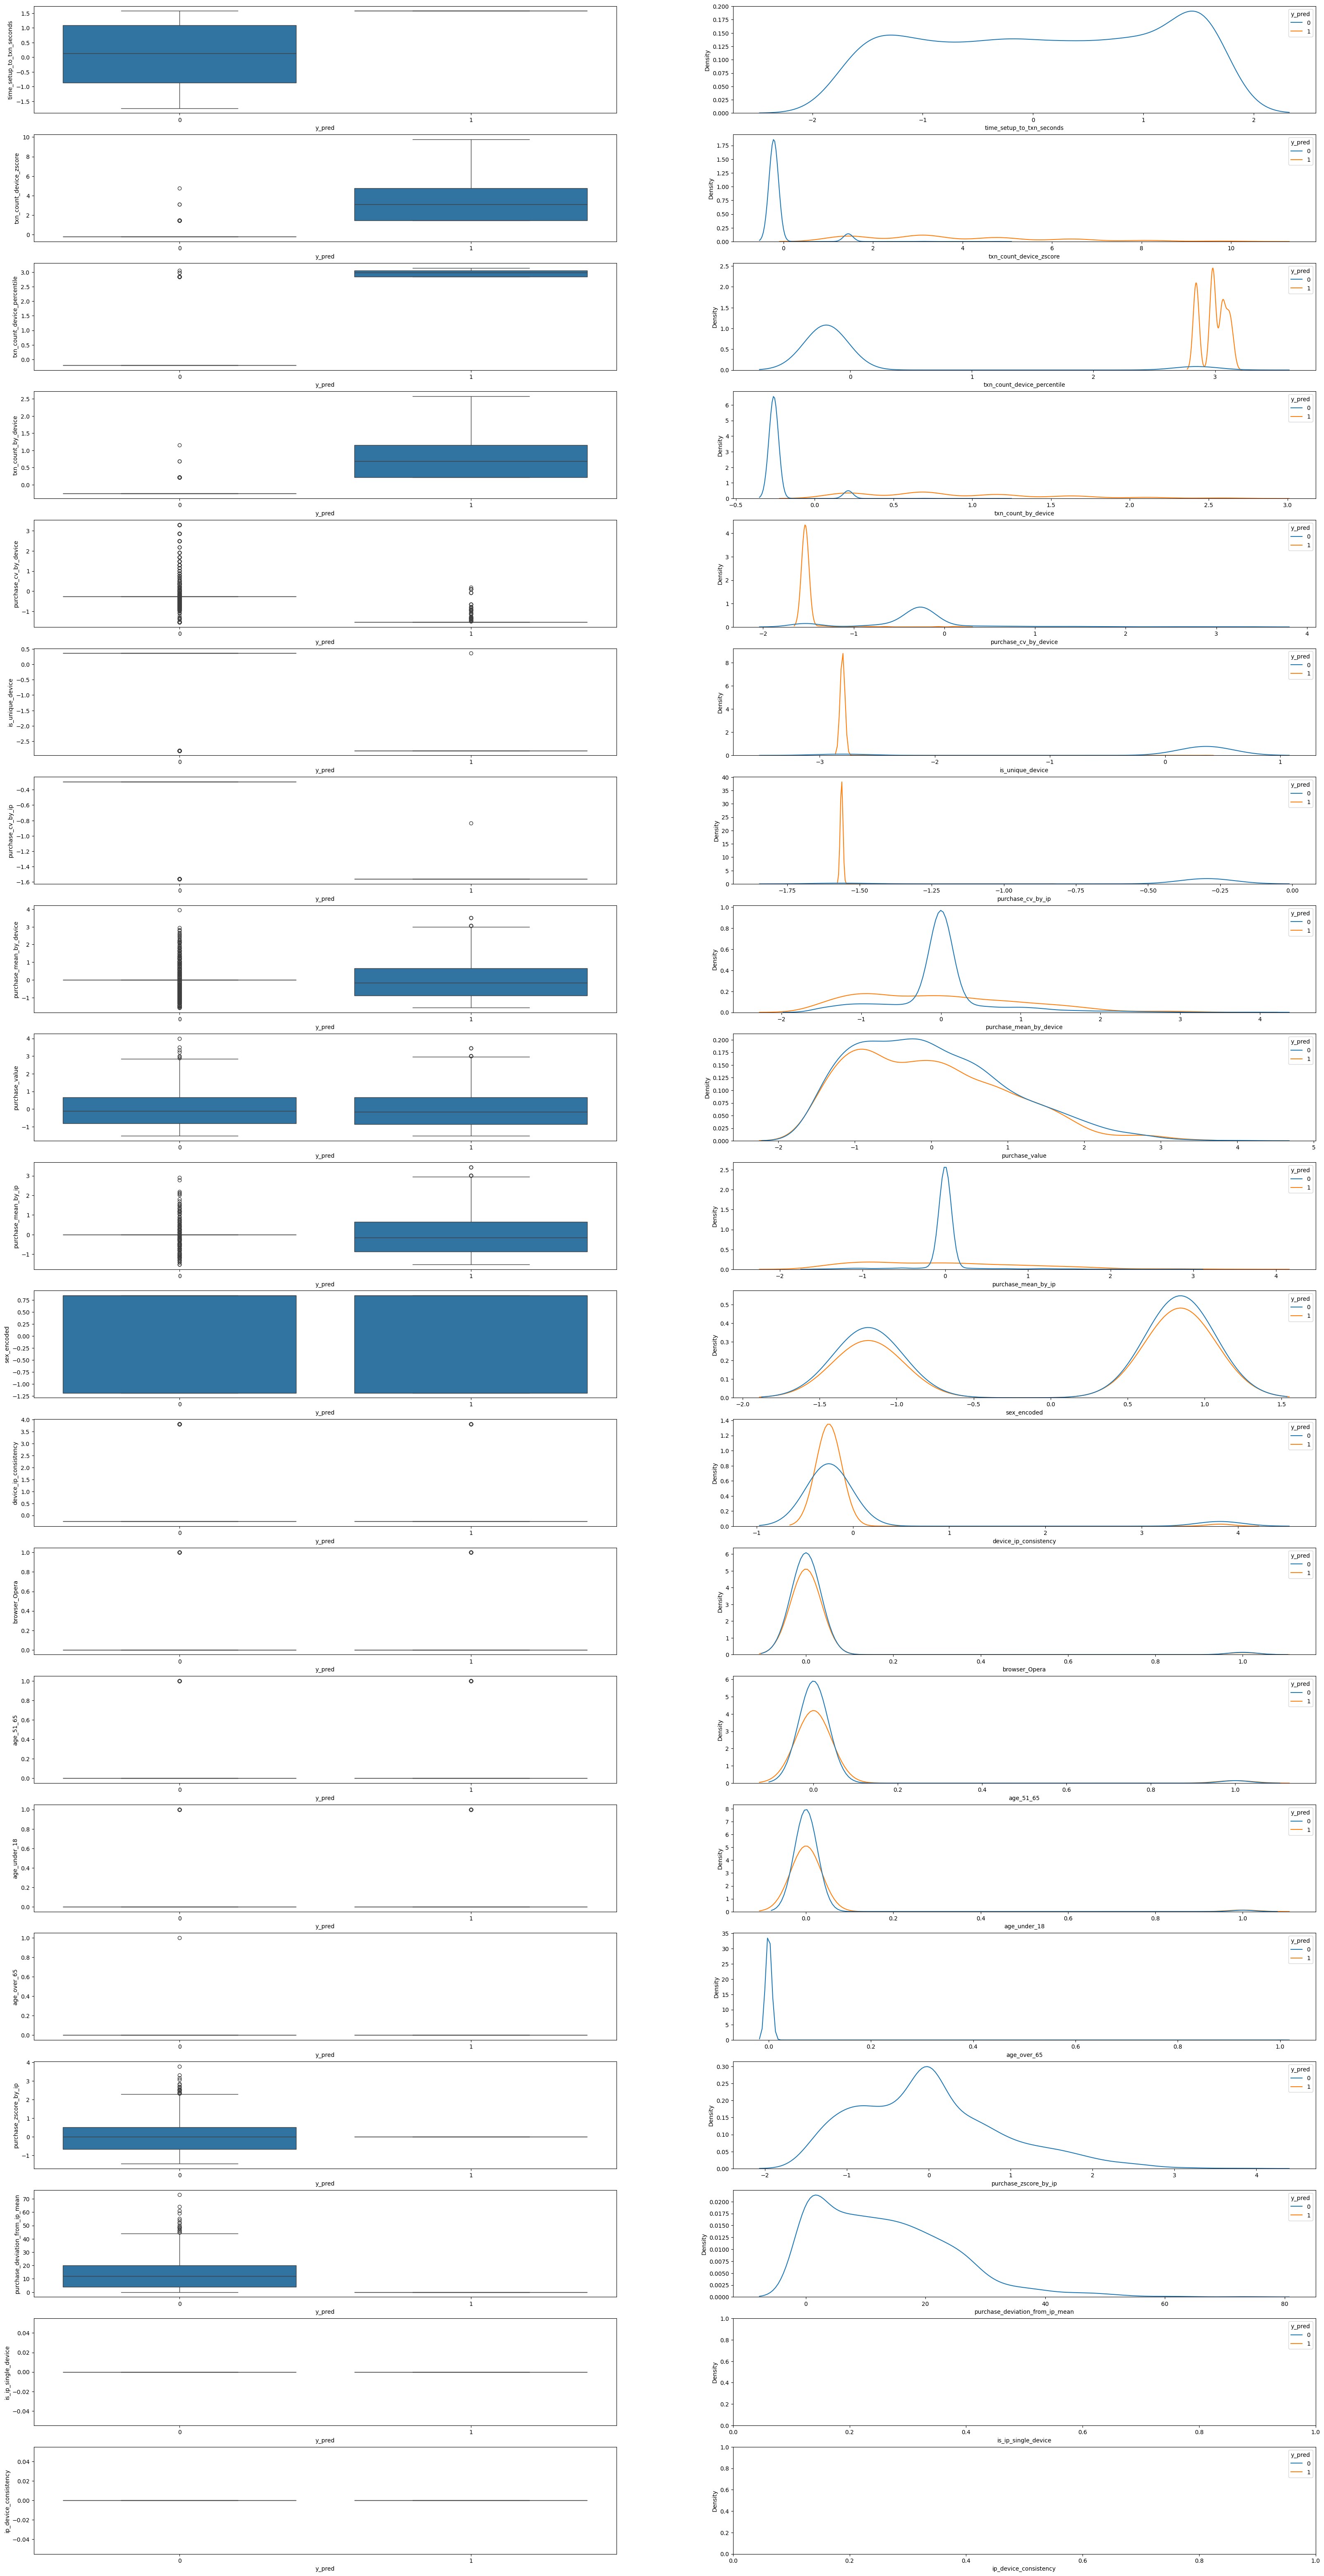

In [28]:
data = modified_test_df_rf[modified_test_df_rf["y_true"]==1]
important_feature_diff(data, rf_importance, "y_pred", n=10)

## XGBoost

ROC-AUC: 0.7722097440745674

Classification Report:
              precision    recall  f1-score   support

           0     0.9478    0.9998    0.9731     27393
           1     0.9962    0.4675    0.6364      2830

    accuracy                         0.9500     30223
   macro avg     0.9720    0.7337    0.8048     30223
weighted avg     0.9524    0.9500    0.9416     30223

PR AUC (average_precision_score): 0.5156


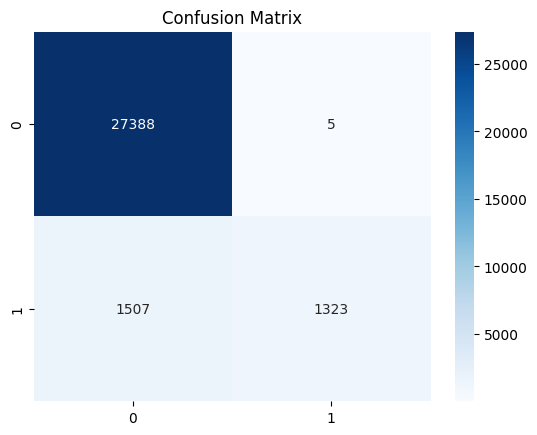

In [29]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=200,
    max_depth=None,
    learning_rate=0.1,
    objective='binary:logistic'
)

y_pred_xgb, modified_test_df_xgb, xgb_model, xgb_importance = fit_predict_join(
    xgb,
    X_train,
    X_test,
    y_train,
    y_test,
    features
)

['txn_count_by_device', 'device_ip_consistency', 'txn_count_by_ip', 'time_setup_to_txn_seconds', 'source_Direct', 'is_unique_device', 'gdp_rank_normalized', 'gdp_rank', 'is_unique_ip', 'age_over_65']


/var/folders/l3/pxhbl0b94cdd7tr_xs9sbypc0000gn/T/ipykernel_11811/2582416916.py:11: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data, x=col, hue=x, ax=ax[i][1])


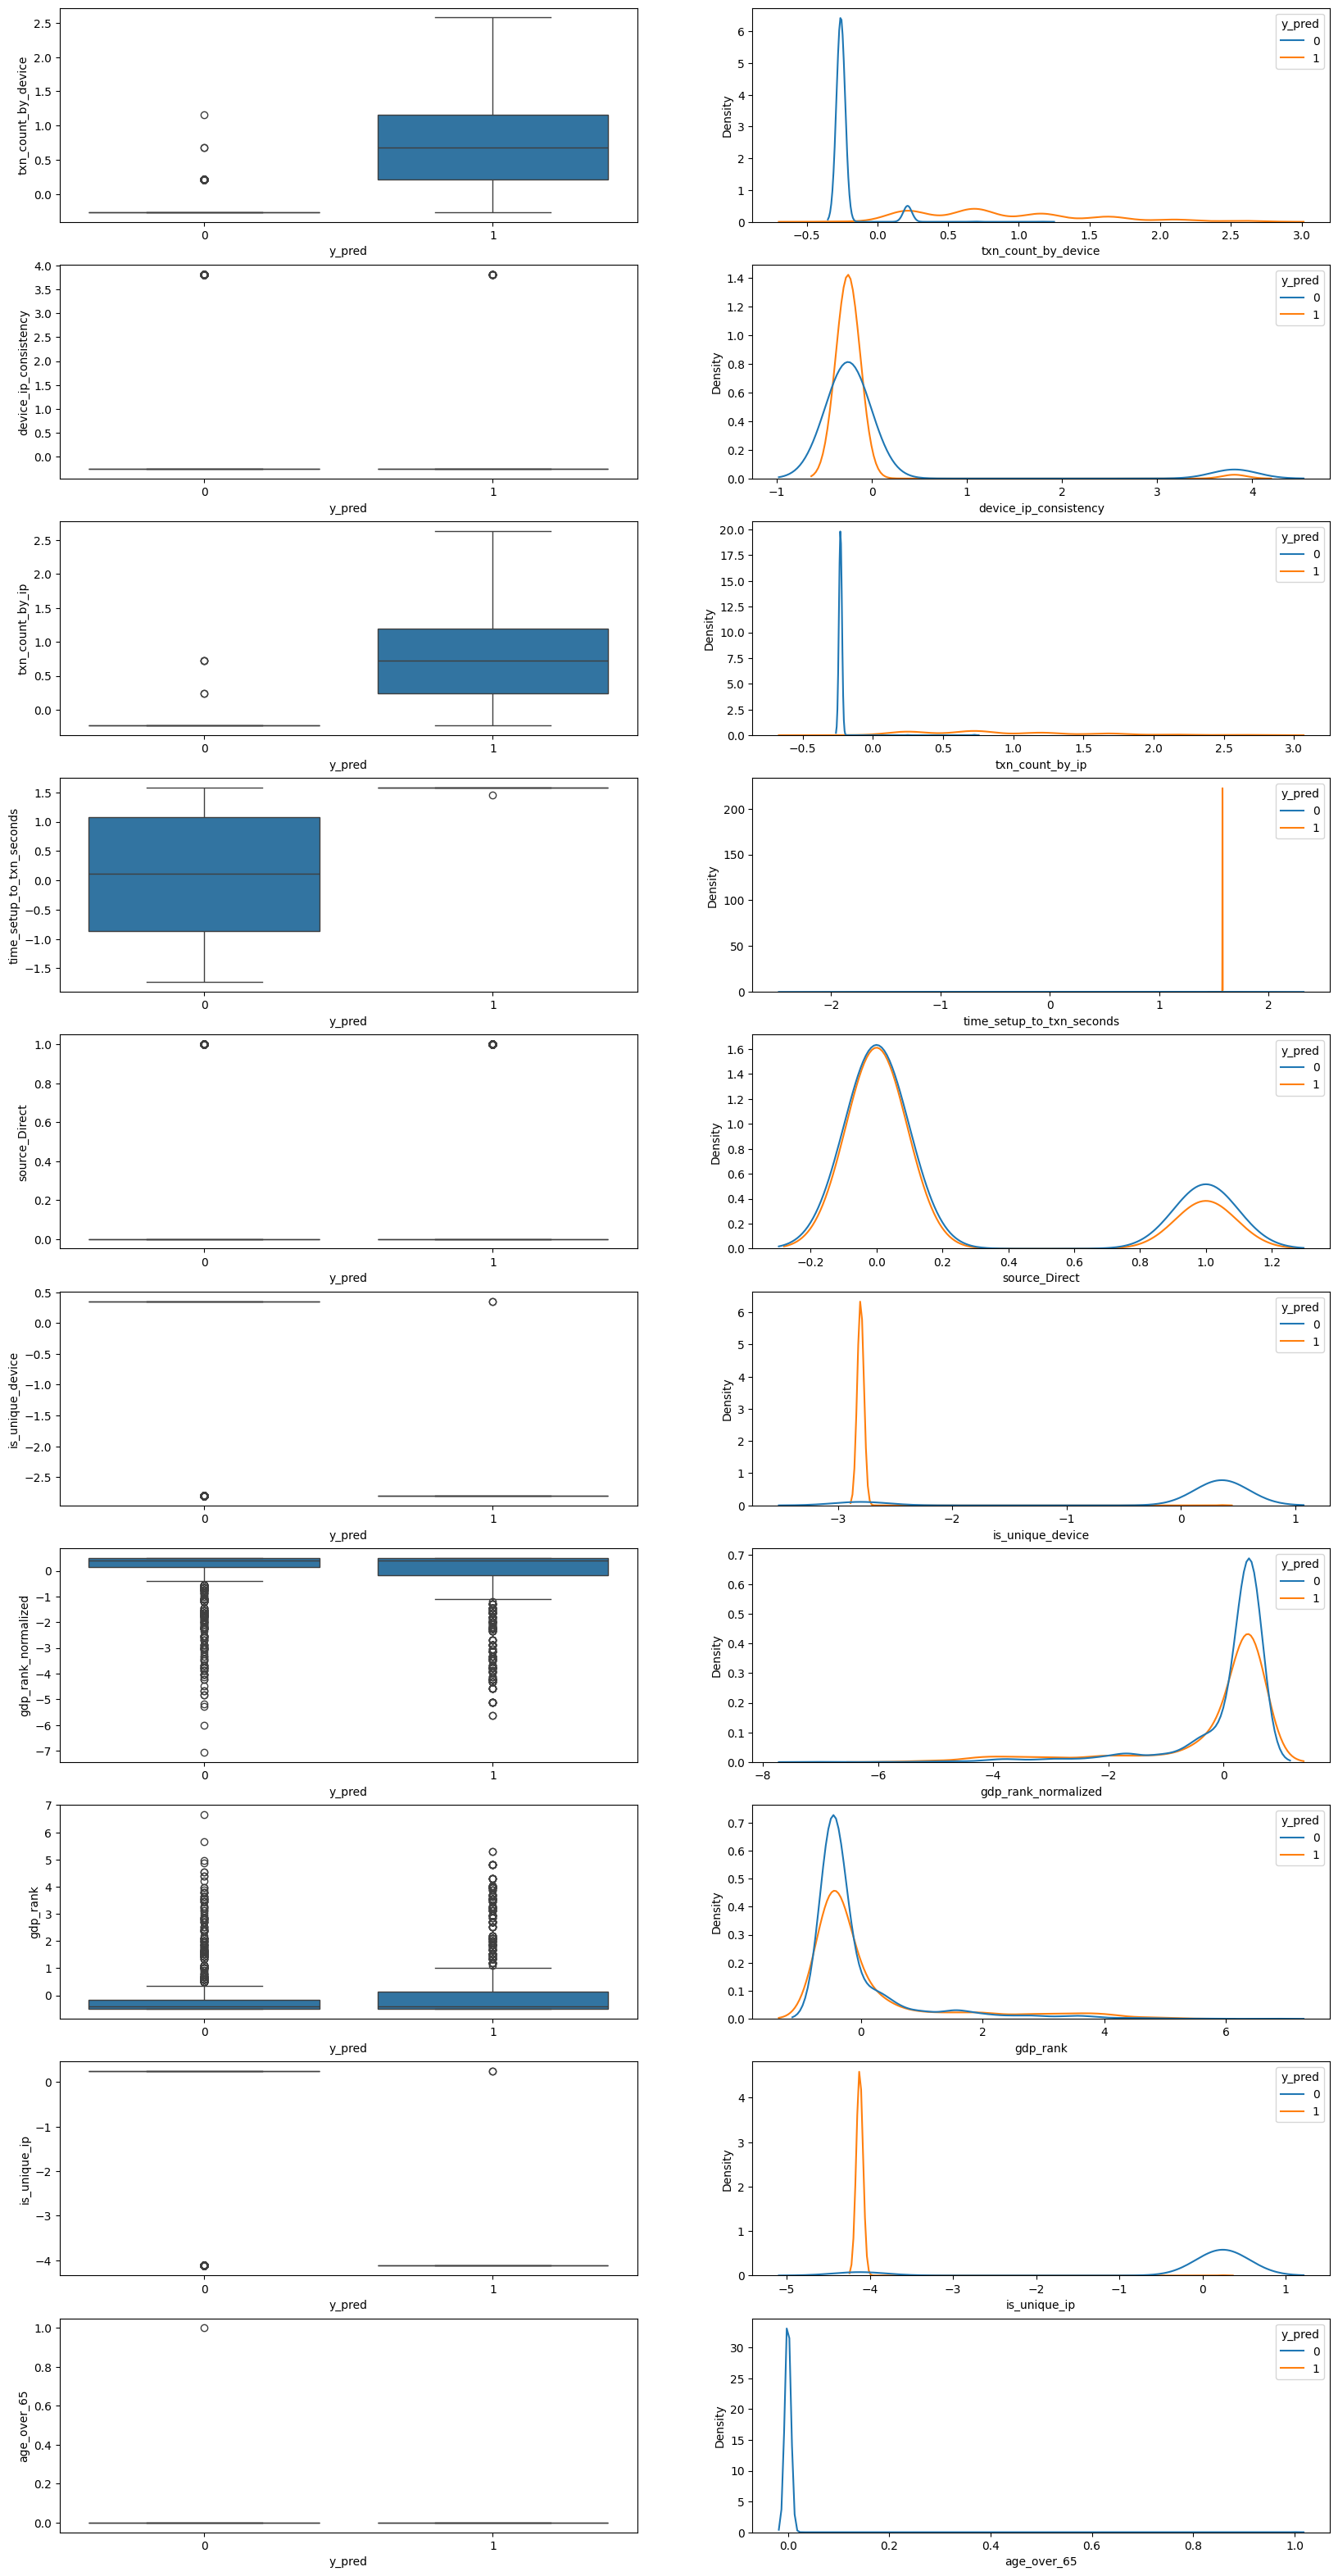

In [30]:
data = modified_test_df_xgb[modified_test_df_xgb["y_true"]==1]
important_feature_diff(data, xgb_importance)

### Investigating for Overfitting
Compare the training and test performance metrics. If models perform significantly better on training and test sets, then the model is overfitting. 

his helps to decide if we should drop features like `fraud_rate_by_month`, because while it is helpful in detecting frauduletn transactions given the number of fraudulent transactions in January as compared to other months, it may not alwyas be the case where January is the month with highest fraudulennt transactions in the real world. 

In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def evalaute_overfitting(models, X_train, y_train):
    results = []
    def compute_metrics(y_true, y_pred, y_proba=None):
        metrics = {
            "Accuracy": accuracy_score(y_true, y_pred),
            "Precision": precision_score(y_true, y_pred, zero_division=0),
            "Recall": recall_score(y_true, y_pred, zero_division=0),
            "F1": f1_score(y_true, y_pred, zero_division=0)
        }
        if y_proba is not None:
            metrics["ROC AUC"] = roc_auc_score(y_true, y_proba)
        else:
            metrics["ROC AUC"] = None
        return metrics
    
    for name, model in models.items():
        y_pred_train = model.predict(X_train)
        try:
            y_proba_train = model.predict_proba(X_train)[:, 1]
        except:
            y_proba_train = None


        train_metrics = compute_metrics(y_train, y_pred_train, y_proba_train)
        results.append({
            "Model": name,
            "Train Accuracy": train_metrics["Accuracy"],
            "Precision": train_metrics["Precision"],
            "Recall": train_metrics["Recall"],
            "F1": train_metrics["Recall"]
        })

    return pd.DataFrame(results)

models = {
    "Logistic Regression": lr_model,
    "Random Forest": rf_model,
    "XGBoost": xgb_model
}
train_performance_df = evalaute_overfitting(models, X_train, y_train)
train_performance_df

Model  Train Accuracy  Precision    Recall        F1
0  Logistic Regression        0.920787   0.563765  0.681389  0.681389
1        Random Forest        1.000000   1.000000  1.000000  1.000000
2              XGBoost        0.959153   0.999687  0.563996  0.563996

## Effect of L1 Regularisation on Logistic Regression model
Logistic Regression had the highest recall on test set. As most large companies prioirtise correctly identifying fraudulent transactions, recall score is prioiritised. Based on the performance of Logistic Regression on the train and test set, overfitting is minimal, and the prioirity would be to apply L1 regularisation for feature selection, given the number of features in the data that are highly correlated

ROC-AUC: 0.7941403358186863

Classification Report:
              precision    recall  f1-score   support

           0     0.9538    0.9920    0.9725     27393
           1     0.8736    0.5350    0.6636      2830

    accuracy                         0.9492     30223
   macro avg     0.9137    0.7635    0.8181     30223
weighted avg     0.9463    0.9492    0.9436     30223

PR AUC (average_precision_score): 0.5109


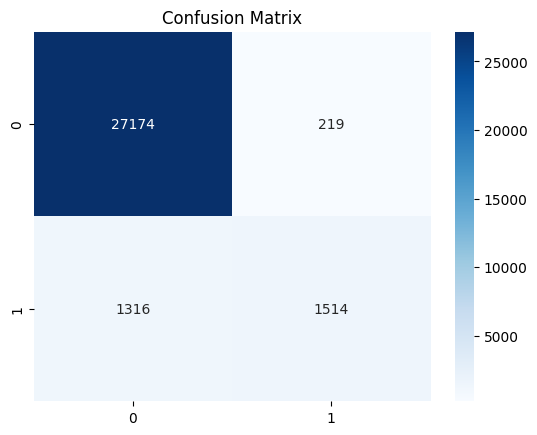

In [32]:
lr_l1 = LogisticRegression(
    penalty='l1',
    solver='liblinear',
    class_weight='balanced', # to handle imbalance, fraud == 0.09
    max_iter=1000,
    random_state=42
)

y_pred_lr_l1, modified_test_df_l1, lr_l1_model, importance_lr_l1 = fit_predict_join(
    lr_l1,
    X_train,
    X_test,
    y_train,
    y_test,
    features
)

In [33]:
importance_lr_l1.head(5)

feature  coefficient
19                is_unique_device    -0.531808
7          txn_count_ip_percentile     0.397752
14  time_since_last_ip_address_txn     0.275427
29             fraud_rate_by_month     0.255005
39                      source_SEO    -0.196482

In [34]:
evalaute_overfitting({"Logistic Regression L1": lr_l1}, X_train, y_train)

Model  Train Accuracy  Precision    Recall        F1
0  Logistic Regression L1        0.920787   0.563765  0.681389  0.681389

Due to the large coefficients on highly correlated features like `txn_count_by_ip` and `fraud_rate_by_month`, decrease `C` to imporve feature selection.

In [ ]:
from sklearn.model_selection import GridSearchCV

def find_best_params(param_grid, model, X_train, y_train):
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=5,
        scoring="recall",
        n_jobs=1
        )

    grid_search.fit(X_train, y_train)

    print("Best C:", grid_search.best_params_)
    print("Best CV recall score:", grid_search.best_score_)

    # Get the best model
    best_lr_model = grid_search.best_estimator_
    return best_lr_model

In [ ]:
lr_param_grid = {
    'penalty': ['l1'],
    'solver': ['liblinear'],
    "class_weight": ["balanced"],
    'C': [0.001, 0.01, 0.1, 1],
    "max_iter": [1000],
    "random_state": [42]
}

best_lr_l1 = find_best_params(lr_param_grid, LogisticRegression(), X_train, y_train)

Best C: {'C': 0.001, 'class_weight': 'balanced', 'max_iter': 1000, 'penalty': 'l1', 'random_state': 42, 'solver': 'liblinear'}
Best CV recall score: 0.7197226967449045


ROC-AUC: 0.8371289046400778

Classification Report:
              precision    recall  f1-score   support

           0     0.9683    0.9330    0.9503     27393
           1     0.5208    0.7042    0.5988      2830

    accuracy                         0.9116     30223
   macro avg     0.7445    0.8186    0.7746     30223
weighted avg     0.9264    0.9116    0.9174     30223

PR AUC (average_precision_score): 0.3944


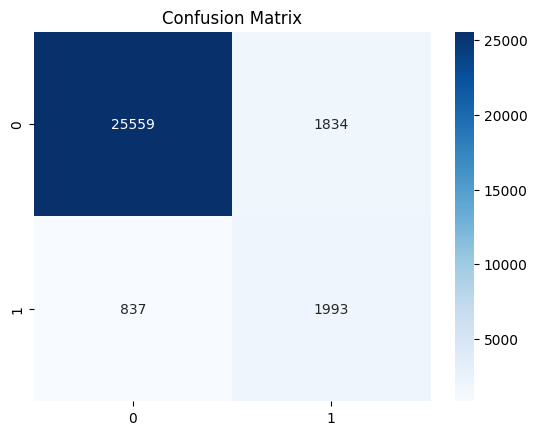

In [ ]:
y_pred_lr_best, modified_test_df_lr_best, lr_best_model, importance_lr_best = fit_predict_join(
    best_lr_l1,
    X_train,
    X_test,
    y_train,
    y_test,
    features
)

In [ ]:
accuracy_score(modified_test_df_lr_best["y_true"], modified_test_df_lr_best["y_pred"])

0.9116235979221123

## Effect of Elastic Net Regularisation on Logistic Regression
When l1 regularisation was applied, the model achieved a higher recall score than when l2 was applied. Model performs slightly better on train than test data, could try to apply l2 regularisation too

Improvements:
Features that contributed most to fraudulent transactions are still highly correlated, instead of applying L1 regularisation, we could handpick features 

ROC-AUC: 0.8315925156397154

Classification Report:
              precision    recall  f1-score   support

           0     0.9630    0.9537    0.9583     27393
           1     0.5900    0.6452    0.6164      2830

    accuracy                         0.9248     30223
   macro avg     0.7765    0.7995    0.7873     30223
weighted avg     0.9281    0.9248    0.9263     30223

PR AUC (average_precision_score): 0.4139


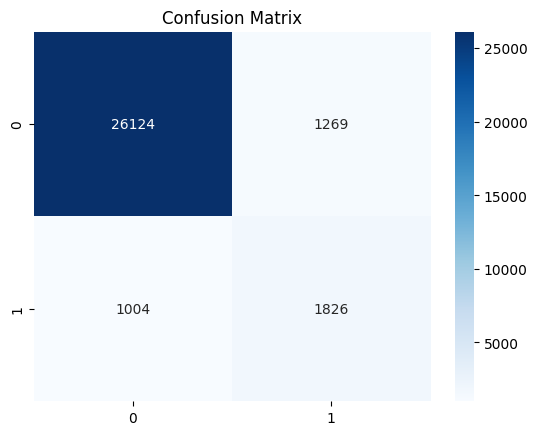

In [ ]:
lr_elastic = LogisticRegression(
    penalty='elasticnet',
    solver='saga',
    class_weight='balanced', # to handle imbalance, fraud == 0.09
    max_iter=1000,
    random_state=42,
    l1_ratio=0.5
)

y_pred_lr_e, modified_test_df_e, lr_e_model, importance_lr_e = fit_predict_join(
    lr_elastic,
    X_train,
    X_test,
    y_train,
    y_test,
    features
)

## Hyperparameter Tuning with Random Forest

Based on the difference between the train and test scores of the `rf` model, there is overfitting. Reduce overfitting by increasing `min_samples_split`, `min_samples_leaf`, decreasing `max_depth`.

ROC-AUC: 0.8404844857969054

Classification Report:
              precision    recall  f1-score   support

           0     0.9673    0.9434    0.9552     27393
           1     0.5577    0.6912    0.6173      2830

    accuracy                         0.9198     30223
   macro avg     0.7625    0.8173    0.7863     30223
weighted avg     0.9289    0.9198    0.9235     30223

PR AUC (average_precision_score): 0.4144


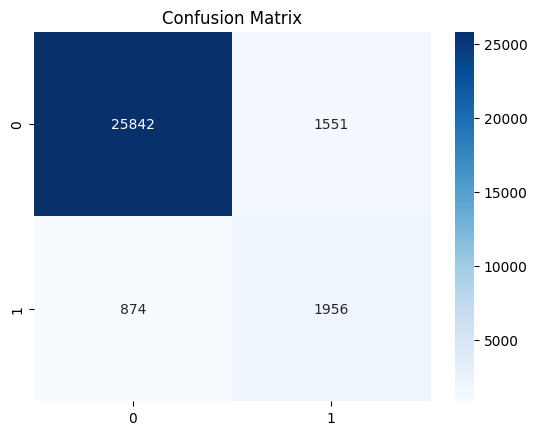

Cannot output importance of features: 'RandomForestClassifier' object has no attribute 'coef_'


In [ ]:
rf_md10 = RandomForestClassifier(
    n_estimators=200,              # number of trees
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

y_pred_rfmd, modified_test_df_rfmd, rfmd_best_model, importance_rfmd = fit_predict_join(
    rf_md10,
    X_train,
    X_test,
    y_train,
    y_test,
    features
)

ROC-AUC: 0.8420636723498136

Classification Report:
              precision    recall  f1-score   support

           0     0.9680    0.9402    0.9539     27393
           1     0.5471    0.6996    0.6140      2830

    accuracy                         0.9176     30223
   macro avg     0.7576    0.8199    0.7840     30223
weighted avg     0.9286    0.9176    0.9221     30223

PR AUC (average_precision_score): 0.4109


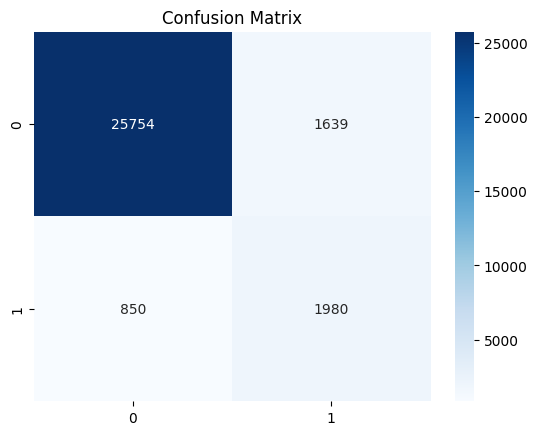

Cannot output importance of features: 'RandomForestClassifier' object has no attribute 'coef_'


In [ ]:
rf_md10_mss10_mss5 = RandomForestClassifier(
    n_estimators=100,              # number of trees
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

y_pred_rf_md10_mss10_mss5, modified_test_df_rf_md10_mss10_mss5, rf_md10_mss10_mss5_best_model, importance_rf_md10_mss10_mss5 = fit_predict_join(
    rf_md10_mss10_mss5, 
    X_train,
    X_test,
    y_train,
    y_test,
    features
)

In [ ]:
evalaute_overfitting({"rf_md10_mss10_mss5": rf_md10_mss10_mss5_best_model}, X_train,y_train)

Model  Train Accuracy  Precision    Recall        F1
0  rf_md10_mss10_mss5        0.918256   0.548481  0.719018  0.719018

## Hyperparameter Tuning with XGBoost

In [ ]:
xgb_param_grid = {
    "n_estimators": [200, 300],
    "max_depth": [20, 30],
    "min_child_weight": [1],
    "learning_rate": [0.1]
}

best_xgb_1 = find_best_params(xgb_param_grid, XGBClassifier(), X_train, y_train)

Best C: {'learning_rate': 0.1, 'max_depth': 20, 'min_child_weight': 1, 'n_estimators': 300}
Best CV recall score: 0.551981567718937


In [ ]:
evalaute_overfitting({"best XGB": best_xgb_1}, X_train, y_train)

Model  Train Accuracy  Precision    Recall        F1
0  best XGB        0.996244        1.0  0.959898  0.959898

### `best_xgb_1` has a significantly lower recall score on test data as compared to train data, reduce overfitting by:
- reducing `n_estimators`
- reducing `learning_rate`, but need larger `n_estimators`
- reducing `max_depth`
- increasing `lambda` (L2 Regularisation)
- increasing `gamma` -> quadratic objective has to improve more significantly for a split to be justified
- increasing `alpha` (L1 Regularisation) -> zero out small signals
- increasing `min_child_weight` -> prevents splitting nodes with too little info, stabilising against overfitting to few samples


In [ ]:
xgb_param_grid_l2 = {
    "n_estimators": [100, 200],
    "max_depth": [20],
    "learning_rate": [0.01, 0.05, 0.1],
    "lambda": [1, 1.2]
}

best_xgb_l2 = find_best_params(xgb_param_grid_l2, XGBClassifier(), X_train, y_train)

Best C: {'lambda': 1, 'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 200}
Best CV recall score: 0.5510100312794951


In [ ]:
evalaute_overfitting({"Best XGB with L2": best_xgb_l2}, X_train, y_train)

Model  Train Accuracy  Precision    Recall        F1
0  Best XGB with L2         0.98923        1.0  0.884992  0.884992

In [ ]:
xgb_param_grid_est = {
    "n_estimators": [200, 300, 400],
    "max_depth": [10, 15, 20],
    "learning_rate": [0.1]
}

best_xgb_est = find_best_params(xgb_param_grid_est, XGBClassifier(), X_train, y_train)

Best C: {'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 400}
Best CV recall score: 0.5524230688226897


In [ ]:
evalaute_overfitting({"Best XGB with est": best_xgb_est}, X_train, y_train)

Model  Train Accuracy  Precision   Recall       F1
0  Best XGB with est        0.999156        1.0  0.99099  0.99099

### Hyperparameters from ChatGPT after overfitting still

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    random_state=42,
    n_jobs=-1,
    use_label_encoder=False
)

param_grid = {
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'scale_pos_weight': [5, 10, 15, 20]  # adjust based on class imbalance
}

best_xgb = find_best_params(param_grid, xgb, X_train, y_train)

/Users/han-ying/Downloads/ecommerce-fraud/ecommece_venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [05:35:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/han-ying/Downloads/ecommerce-fraud/ecommece_venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [05:35:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/han-ying/Downloads/ecommerce-fraud/ecommece_venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [05:35:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/han-ying/Downloads/ecommerce-fraud/ecommece_venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarn

Best C: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'scale_pos_weight': 20, 'subsample': 1.0}
Best CV recall score: 0.7591185188652018


## Dropping highly correlated features

### Effect of Dropping `fraud_rate_by_month`

In [ ]:
X_train_1 = X_train.drop(columns=["fraud_rate_by_month"], inplace=False)
X_test_1 = X_test.drop(columns=["fraud_rate_by_month"], inplace=False)

ROC-AUC: 0.8296333991596471

Classification Report:
              precision    recall  f1-score   support

           0     0.9628    0.9552    0.9590     27393
           1     0.5973    0.6431    0.6194      2830

    accuracy                         0.9260     30223
   macro avg     0.7801    0.7992    0.7892     30223
weighted avg     0.9286    0.9260    0.9272     30223

PR AUC (average_precision_score): 0.4176


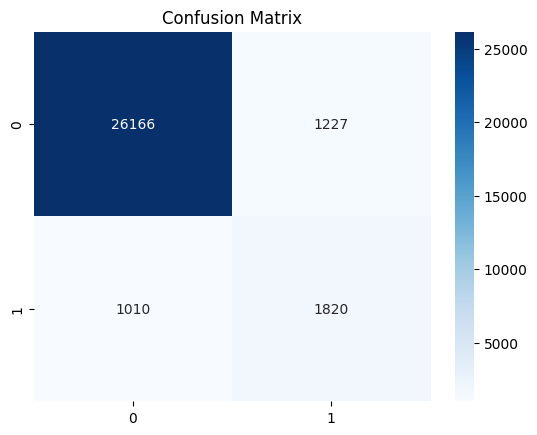

In [ ]:
lr_1 = LogisticRegression(
    solver='liblinear',
    class_weight='balanced', # to handle imbalance, fraud == 0.09
    max_iter=1000,
    random_state=42
)

y_pred_lr_1, modified_test_df_1, lr_model_1, importance_1 = fit_predict_join(
    lr_1,
    X_train_1,
    X_test_1,
    y_train,
    y_test,
    features
)

ROC-AUC: 0.8354426455186573

Classification Report:
              precision    recall  f1-score   support

           0     0.9530    0.9989    0.9754     27393
           1     0.9808    0.5230    0.6822      2830

    accuracy                         0.9544     30223
   macro avg     0.9669    0.7610    0.8288     30223
weighted avg     0.9556    0.9544    0.9480     30223

PR AUC (average_precision_score): 0.5576


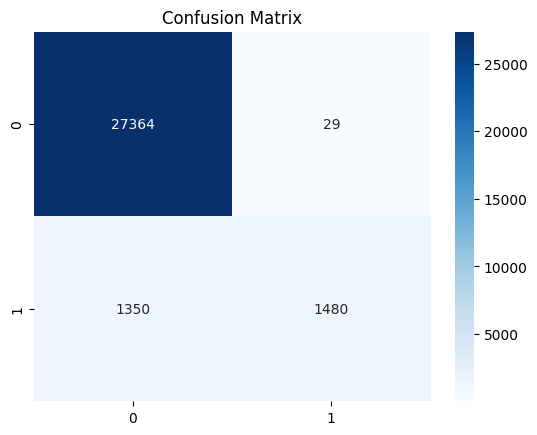

Cannot output importance of features: 'RandomForestClassifier' object has no attribute 'coef_'


In [ ]:
rf_1 = RandomForestClassifier(
    n_estimators=200,              # number of trees
    max_depth=None,                # let trees grow fully (you can tune later)
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight='balanced',       # handle class imbalance
    random_state=42,
    n_jobs=-1                      # use all cores
)

y_pred_rf_1, modified_test_df_rf_1, rf_model_1, rf_importance_1 = fit_predict_join(
    rf,
    X_train_1,
    X_test_1,
    y_train,
    y_test,
    features
)


ROC-AUC: 0.8357324528628512

Classification Report:
              precision    recall  f1-score   support

           0     0.9532    0.9990    0.9755     27393
           1     0.9815    0.5251    0.6842      2830

    accuracy                         0.9546     30223
   macro avg     0.9673    0.7620    0.8299     30223
weighted avg     0.9558    0.9546    0.9483     30223

PR AUC (average_precision_score): 0.5598


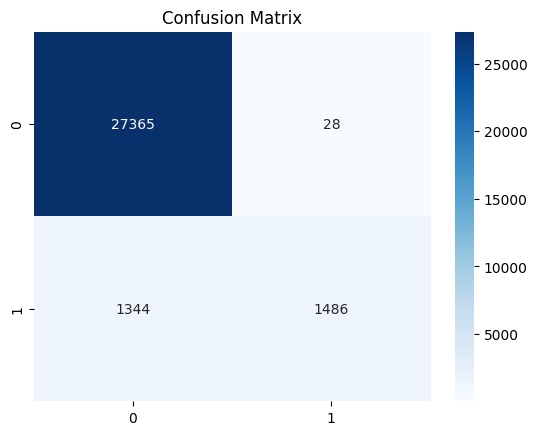

Cannot output importance of features: Coefficients are not defined for Booster type None


In [ ]:
xgb_1 = XGBClassifier(
    n_estimators=200,
    max_depth=None,
    learning_rate=0.1,
    objective='binary:logistic'
)

y_pred_xgb_1, modified_test_df_xgb_1, xgb_model_1, xgb_importance_1 = fit_predict_join(
    xgb,
    X_train_1,
    X_test_1,
    y_train,
    y_test,
    features
)

In [ ]:
X_train["purchase_cv_by_device"].value_counts()

purchase_cv_by_device
-1.526727    6423
 0.139727    2278
 0.263168    2277
 0.199243    2232
 0.032214    2210
             ... 
-0.370334       1
 0.040141       1
 0.672484       1
-0.315249       1
-1.434199       1
Name: count, Length: 1660, dtype: int64

In [ ]:
X_train.columns

Index(['purchase_value', 'txn_count_by_device', 'txn_count_by_ip',
       'txn_count_device_zscore', 'txn_count_ip_zscore',
       'txn_count_device_percentile', 'txn_count_ip_percentile',
       'device_ip_consistency', 'is_device_single_ip', 'ip_device_consistency',
       'is_ip_single_device', 'time_setup_to_txn_seconds',
       'time_since_last_device_id_txn', 'time_since_last_ip_address_txn',
       'purchase_std_by_device', 'purchase_mean_by_device',
       'purchase_std_by_ip', 'purchase_mean_by_ip', 'is_unique_device',
       'is_unique_ip', 'purchase_cv_by_device', 'purchase_cv_by_ip',
       'purchase_deviation_from_device_mean',
       'purchase_deviation_from_ip_mean', 'purchase_zscore_by_device',
       'purchase_zscore_by_ip', 'transaction_month', 'month_sin', 'month_cos',
       'fraud_rate_by_month', 'gdp', 'gdp_rank', 'gdp_rank_normalized',
       'sex_encoded', 'cluster_3', 'cluster_5', 'cluster_8', 'source_Ads',
       'source_Direct', 'source_SEO', 'browser_Chrome'

In [ ]:
X_train["purchase_zscore_by_device"].value_counts()

purchase_zscore_by_device
-0.000456     111808
-2.767490        150
-1.686896        148
 1.685983        148
-2.385442        148
               ...  
-5.507979          1
 0.761757          1
-3.865983          1
 3.998465          1
 17.910391         1
Name: count, Length: 453, dtype: int64

In [ ]:
train_df["device_id"].nunique

<bound method IndexOpsMixin.nunique of 55555     QNXCOUPOQDLCL
98502     KUZCDUJXEMAZM
139685    GSZFXRRBDXPAS
34425     JCZMYSCYHQJYX
124885    KDJNIXXMMUJDB
              ...      
138430    EFOOYUHDITTMV
20003     NPCINKNBLNGMJ
28523     STUYPGBSDQDGK
16251     NCJHOXSXHHRZP
121794    XZXFZLEOEHRRE
Name: device_id, Length: 120889, dtype: object>